# Generating Model Card for Multimodal Classification with PyTorch and Roberta Models

This notebook provides an example of generating a model card for multimodal vision and text classification using PyTorch and Roberta models. The model is trained to classify meme images and text to identify hateful memes. Finally, we use the Intel Model Card Generator for analyzing the performance of our model.

1. [Data Collection from Hugging Face Dataset](#2.-Download-Dataset-from-Hugging-Face-Datasets)
2. [Preprocess Text and Image Features](#3.-Transform-the-Image-and-Text-Features-of-the-Dataset)
3. [Build the PyTorch Model](#4.-Build-Model)
4. [Train Model](#5.-Train-Model)
5. [Save Model](#6.-Save-Model)
6. [Evaluate Model Performance and Process Output for Model Card](#7.-Evaluate-Model)
7. [Generate Model Card with Intel Model Card Generator](#9.-Generate-Model-Card)

# 1. Download and Import Dependencies

In [ ]:
!pip install evaluate datasets transformers[torch] scikit-learn torchvision Pillow

In [48]:
import torch.nn as nn
import torch.optim as optim
import json
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms
from transformers import RobertaTokenizer, RobertaModel
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
from intel_ai_safety.model_card_gen.model_card_gen import ModelCardGen

# 2. Download Dataset from Hugging Face Datasets

In [ ]:
from datasets import load_dataset

ds = load_dataset("neuralcatcher/hateful_memes")

### Train Test Split

In [7]:
dataset = ds['train'].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'img', 'label', 'text'],
        num_rows: 6800
    })
    test: Dataset({
        features: ['id', 'img', 'label', 'text'],
        num_rows: 1700
    })
})

In [8]:
train_data = dataset["train"]
test_data = dataset["test"]

### Viewing an example Image from the Dataset

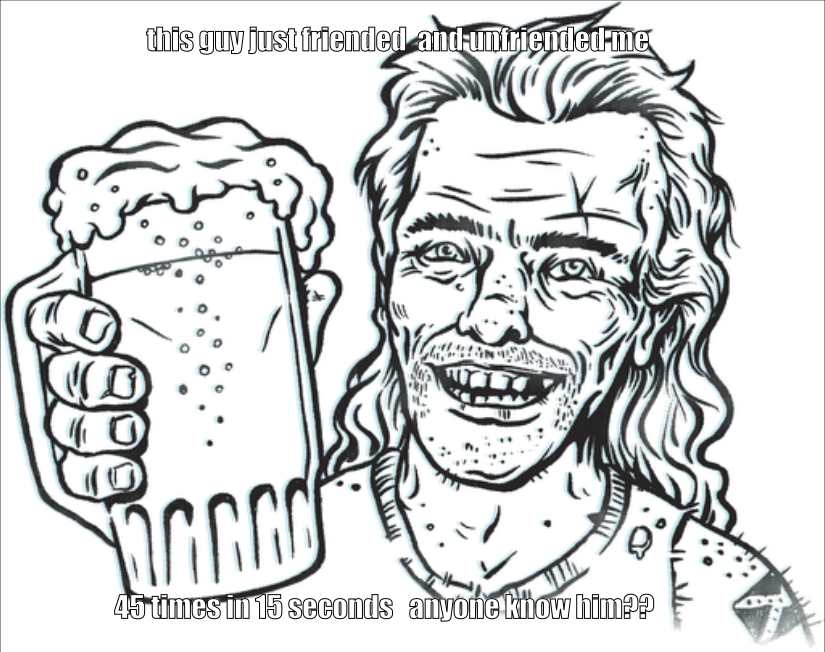

In [10]:
item = train_data[0]
Image.open(item['img']).convert('RGB')

# 3. Transform the Image and Text Features of the Dataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None, tokenizer=None, text_model=None):
        self.data = data
        self.tokenizer = tokenizer
        self.text_classification_model = text_model

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
         ])

        # Process Image
        img = Image.open(item['img']).convert('RGB')
        img = transform(img)

        # Process Text
        text_features = None
        inputs = self.tokenizer(item['text'], return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = self.text_classification_model(**inputs)
            text_features = outputs.last_hidden_state.mean(dim=1).squeeze(0)

        return {
            "image": img,
            "text_features": text_features,
            "label": torch.tensor(item['label'], dtype=torch.long)
        }

### Load the Text Model

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
text_model = RobertaModel.from_pretrained('roberta-base')

In [13]:
train_dataset = CustomDataset(train_data, tokenizer=tokenizer, text_model=text_model)
test_dataset = CustomDataset(test_data, tokenizer=tokenizer, text_model=text_model)

### Preparing Data Loaders for Training and Testing

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4. Build Model

In [17]:
class HatefulMemeClassifier(nn.Module):
    def __init__(self, text_dim, img_dim, num_classes):
        super(HatefulMemeClassifier, self).__init__()
        self.text_fc1 = nn.Linear(text_dim, 512)
        self.text_bn1 = nn.BatchNorm1d(512)
        self.text_fc2 = nn.Linear(512, 256)
        self.text_bn2 = nn.BatchNorm1d(256)
        
        self.img_fc1 = nn.Linear(img_dim, 512)
        self.img_bn1 = nn.BatchNorm1d(512)
        self.img_fc2 = nn.Linear(512, 256)
        self.img_bn2 = nn.BatchNorm1d(256)
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256 * 2, num_classes)

    def forward(self, text_features, img_features):
        text_out = F.relu(self.text_bn1(self.text_fc1(text_features)))
        text_out = self.dropout(F.relu(self.text_bn2(self.text_fc2(text_out))))
        
        img_out = F.relu(self.img_bn1(self.img_fc1(img_features)))
        img_out = self.dropout(F.relu(self.img_bn2(self.img_fc2(img_out))))
        
        combined = torch.cat((text_out, img_out), dim=1)
        return self.fc(combined)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HatefulMemeClassifier(text_dim=768, img_dim=3 * 224 * 224, num_classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 5. Train Model

In [ ]:
epochs=5
i = 0 
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        i+=1
        images = batch['image'].to(device).view(batch['image'].size(0), -1)
        text_features = batch['text_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(text_features, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(i)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# 6. Save Model
Save the offline version of trained multimodal classification model.

In [ ]:
torch.save(model.state_dict(), 'hatefule_meme_classifier.pth')

# 7. Evaluate Model

### Evaluating Model Performance on Test Dataset

In [31]:
model.eval()
correct, total = 0, 0
y_pred_prob = []
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device).view(batch['image'].size(0), -1)
        text_features = batch['text_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(text_features, images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred_prob.extend(probs.cpu().numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 68.71%


# 8. Transform Output for Model Card
We will create metrics_by_threshold dataframe containing performance metrics at threshold.

In [ ]:
thetas = np.linspace(0, 1, 1001)

metrics_dict ={
    'threshold': thetas,
    'precision': [precision_score(test_data['label'], y_pred_prob > theta) for theta in thetas],
    'recall': [recall_score(test_data['label'], y_pred_prob > theta) for theta in thetas],
    'f1': [f1_score(test_data['label'], y_pred_prob > theta) for theta in thetas],
    'accuracy' : [accuracy_score(test_data['label'], y_pred_prob > theta) for theta in thetas]
}

In [41]:
metrics_by_threshold = pd.DataFrame.from_dict(metrics_dict)

In [42]:
metrics_by_threshold.to_csv('metrics_by_threshold_multimodal.csv', index=False)  

# 9. Generate Model Card

Simply load the metrics_by_threshold dataframe into the `ModelCardGen.generate` class method to build a model card.

In [43]:
metrics_by_threshold = pd.read_csv("metrics_by_threshold_multimodal.csv")

In [52]:
mc =  {
    "schema_version": "0.0.1",
    "model_details": {
        "name": "Hateful Meme Classification",
        "version": {
            "name": "0.1",
            "date": "2024"
        },
        "graphics": {},

        "citations": [
             {
                "citation": '''@misc{liu2019robertarobustlyoptimizedbert,
                              title={RoBERTa: A Robustly Optimized BERT Pretraining Approach}, 
                              author={Yinhan Liu and Myle Ott and Naman Goyal and Jingfei Du and Mandar Joshi and Danqi Chen and Omer Levy and Mike Lewis and Luke Zettlemoyer and Veselin Stoyanov},
                              year={2019},
                              eprint={1907.11692},
                              archivePrefix={arXiv},
                              primaryClass={cs.CL},
                              url={https://arxiv.org/abs/1907.11692}, 
                                }'''
                              
             },
            {
                "citation": '''@misc{kiela2021hatefulmemeschallengedetecting,
                              title={The Hateful Memes Challenge: Detecting Hate Speech in Multimodal Memes}, 
                              author={Douwe Kiela and Hamed Firooz and Aravind Mohan and Vedanuj Goswami and Amanpreet Singh and Pratik Ringshia and Davide Testuggine},
                              year={2021},
                              eprint={2005.04790},
                              archivePrefix={arXiv},
                              primaryClass={cs.AI},
                              url={https://arxiv.org/abs/2005.04790}, 
                                }
                            '''
            }
        ],
        "overview": 'This example of a multimodal PyTorch model uses text features generated by the RoBERTa model and meme images to classify a meme image and text as either hateful or normal. The PyTorch model is trained on the Hateful Memes Challenge dataset created by Facebook AI for detecting hate speech in multimodal memes.',
    }
}

In [53]:
mcg = ModelCardGen.generate(metrics_by_threshold=metrics_by_threshold, model_card=mc)
mcg

In [50]:
mcg.export_html('ModelCard.html')